# Visualizing Security wait times for Dane County airport using plotnine.

In [3]:
import plotnine as pn
import pandas as pd
import numpy as np

pn.options.figure_size = (14, 4.8)
#Read in csv from github.
SD = pd.read_csv("https://raw.githubusercontent.com/mjholt02/SharedData/master/security.csv", 
                 header=None, 
                 names = ["main","precheck","datetime"], 
                parse_dates = ['datetime'])


#Tidy up the data and clean up the unknown times which we're unable to parse.
SD = SD.melt(id_vars = ['datetime'], var_name = 'entrance',value_name = 'timeStr')
SD = SD.query('timeStr != "unknown"')

#Break apart the time into a min/max and then average to get our time value we will use moving forward.
mySplit = SD['timeStr'].str.split(r"-| ", expand=True).iloc[:,[0,1]].apply(pd.to_numeric)
mySplit.columns = ["min","max"]
mySplit['Avg'] = mySplit.mean(axis=1)
SD = SD.join(mySplit)

#Create function to allow flexibility to plot wait times for a range of specified dates.
def myPlot(df,start='',end='',window = '10Min'):
    
    #Create logic to filter by dates if provided, otherwise select max/min dates from data.
    baseDate = pd.to_numeric(pd.to_datetime('today').strftime('%Y%d%m'))

    if start == "": startDate = pd.to_numeric(df['datetime'].min().date().strftime('%Y%d%m'))
    elif start != "": startDate = pd.to_numeric(start)

    if end == "": endDate = pd.to_numeric(df['datetime'].max().date().strftime('%Y%d%m'))
    elif end != "": endDate = pd.to_numeric(end)

    df['TD0'] = baseDate - pd.to_numeric(SD['datetime'].dt.strftime('%Y%d%m'))
    df['TDS'] = baseDate - startDate
    df['TDE'] = baseDate - endDate

    dfsub = df.query('TD0 <= TDS and TD0 >= TDE').copy()

    #Create a dateTime2 which changes everything to the same day which allows us to do our rolling window 
    #over just time and not dateTime. 
    dfsub['datetime2'] = pd.to_datetime('2020-12-12 ' + dfsub['datetime'].dt.strftime('%H:%M'))
    
    df2 = dfsub.groupby(['entrance']).resample(window, on = 'datetime2').mean().dropna()
    df2.reset_index(inplace=True)   

    #Create a new time variable which is numeric and not dateTime to make our lives easier when trying to plot this.
    df2['time'] = (df2['datetime2'].dt.hour * 60 + df2['datetime2'].dt.minute)/60
    df2 = df2.sort_values(by=['time'])

    #Create and output plot
    myRange = list(range(0,24))
    title3 = 'from ' + dfsub['datetime'].min().strftime('%d%b%Y')+' to ' +  dfsub['datetime'].max().strftime('%d%b%Y')
    if startDate == endDate: title3 = 'on ' + dfsub['datetime'].min().strftime('%d%b%Y')
    (
    pn.ggplot(df2, pn.aes('time', 'Avg', color='factor(entrance)')) + 
        pn.geom_line() + 
        pn.scales.scale_x_continuous(breaks = myRange, labels = [str(i) for i in myRange]) +
        pn.labs(colour = 'Security Gate', x = 'Time of Day (24Hr)', y = 'Average Wait time (Min)', 
                title = 'Security gate wait time by entrance \n\n Madison, WI ' + title3 ) +
    pn.theme(legend_position = (.83,.75))
    ).draw();

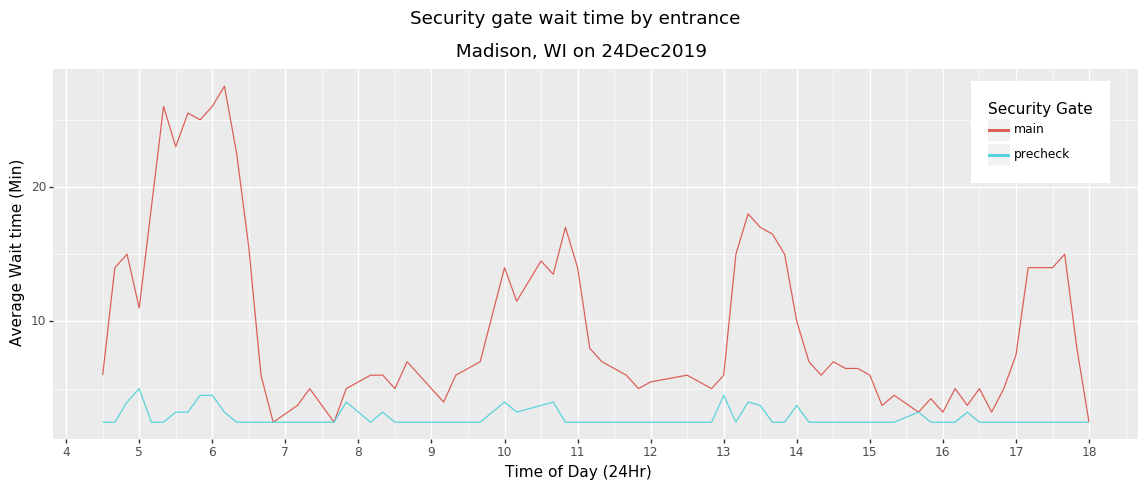

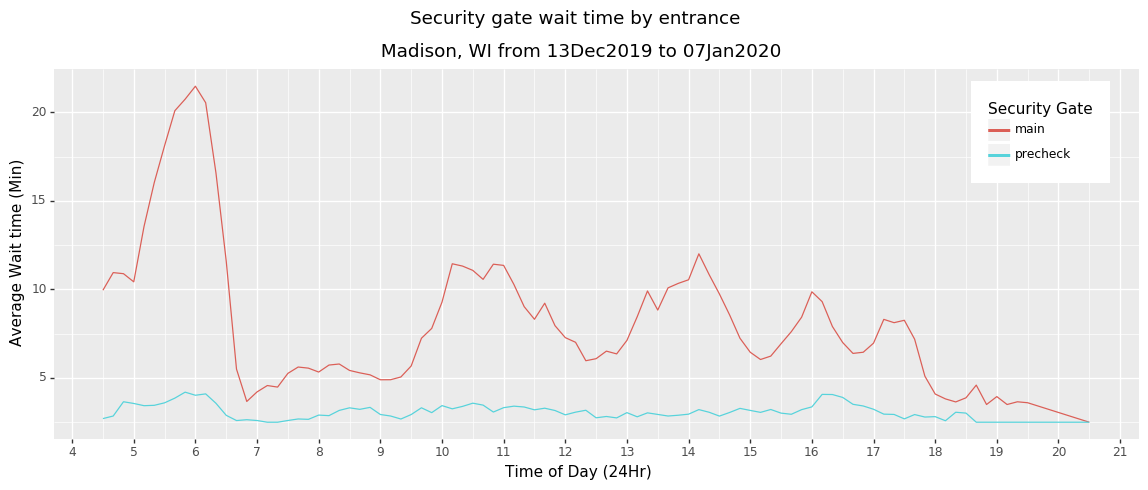

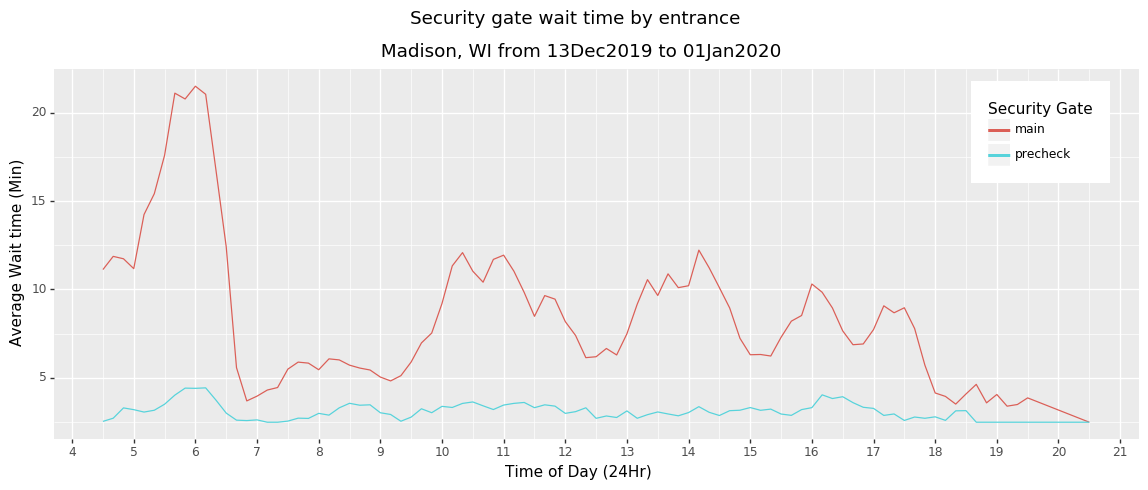

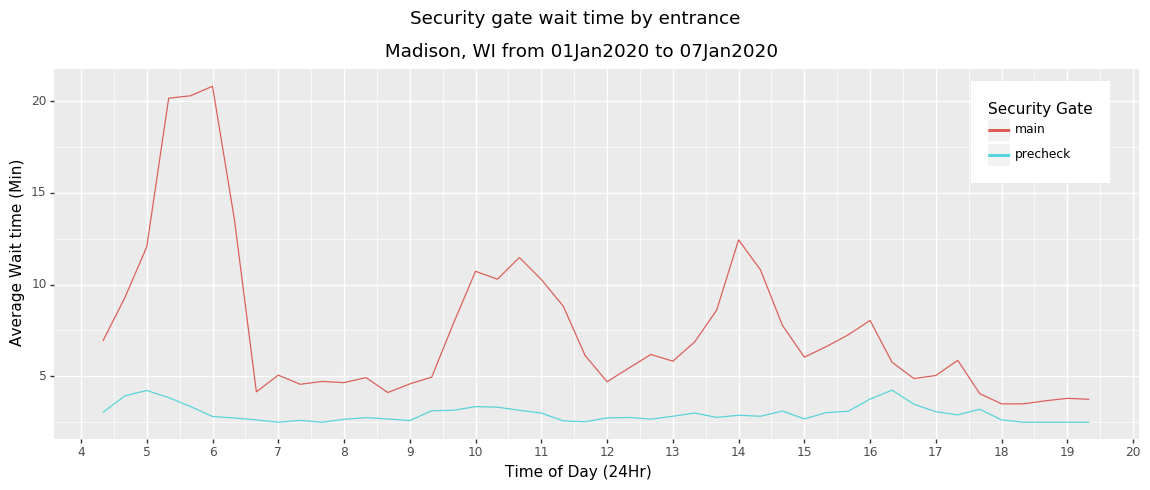

In [4]:
#examples
myPlot(df = SD,start = '20192412',end = '20192412')
myPlot(df = SD)
myPlot(df = SD,end = '20200101')
myPlot(df = SD,start = '20200101',window = '20Min')
